In [40]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from mpl_toolkits import mplot3d
from numpy.random import uniform


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParamsDefault

import keras
from keras import initializers
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout 
from keras.layers import LeakyReLU, Flatten, AveragePooling2D, BatchNormalization
from keras import backend as K
from keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.image import grayscale_to_rgb
from tensorflow import expand_dims


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
import time

from keras import backend as K

from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model
import os

ModuleNotFoundError: No module named 'tensorflow'

# Cutout Regularization

Cutout regularization is when we randomly select square regions in the input data to mask out during training. Like dropout, it's a regularization method to reduce over-fitting. 

According to DeVries et al, one of the big advantage of cutout over dropout is in convolutional layer. In dropout for Conv, we are dropping certain pixels, but neighboring pixels still have similar information, so dropout end-up being not as effective in Conv layers as compared to FC layer. With cutout, we remove group of pixels at the input level, so this might be removing whole objects from the input and all the layers that come after it, forcing the model to consider the full image rather than small key parts of image. 

In [ ]:
import torch
import numpy as np


class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [111]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [112]:
x_train = x_train /255.0
x_test = x_test /255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

In [113]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [32]:
def cutout(img, length =12, n_holes =1):
    h,w,channels = img.shape
    
    new_img = img
    
    for n in range(n_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - length // 2, 0, h)
        y2 = np.clip(y + length // 2, 0, h)
        x1 = np.clip(x - length // 2, 0, w)
        x2 = np.clip(x + length // 2, 0, w)
        
        new_img[y1: y2, x1: x2] = 0
        return new_img

Original images:


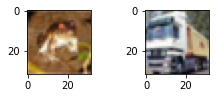

Images with cutout:


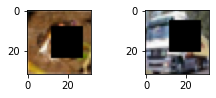

In [115]:
import matplotlib.pyplot as plt
print("Original images:")
for i in range(2):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()
print("Images with cutout:")
for i in range(2):
    plt.subplot(330 + 1 + i)
    plt.imshow(cutout(x_train[i]))
plt.show()

## Keras Resnet model
Code from Keras documentation: https://keras.io/zh/examples/cifar10_resnet/
        

In [3]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 10, 20, 30, 40 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Simple Augmentation to CIFAR10

In [63]:
#split train into validation and train set
cifar10 = tf.keras.datasets.cifar10
(X_train, Y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.2)
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

#convert to float to normalize
x_train = x_train.astype('float32')/255.0
x_val = x_val.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

#categorical format
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

x_train shape: (40000, 32, 32, 3)
x_val shape: (10000, 32, 32, 3)
y_train shape: (40000, 1)
y_val shape: (10000, 1)


In [65]:
#image data generator, flip chance of 50%
datagen = ImageDataGenerator(
    width_shift_range=[-4,4],
    height_shift_range=[-4,4],
    horizontal_flip=0.5, 
    fill_mode= 'constant',
    cval=0
)
datagen.fit(x_train)

In [28]:
p4b_model = resnet_v1(input_shape=input_shape, depth=44)
#print(prob4b_model.summary())
p4b_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [29]:
earlyStop = EarlyStopping()
lr_scheduler = LearningRateScheduler(lr_schedule)

In [31]:
start = time.time()
p4b_aug_hist = p4b_model.fit(
    datagen.flow(x_train, y_train, batch_size=64), 
    epochs=50, 
    validation_data=(x_val,y_val),
    callbacks=[lr_scheduler],
    verbose = 2)
duration = time.time() - start

Epoch 1/50
Learning rate:  0.001
625/625 - 84s - loss: 2.0018 - accuracy: 0.3856 - val_loss: 2.7416 - val_accuracy: 0.3664
Epoch 2/50
Learning rate:  0.001
625/625 - 72s - loss: 1.5732 - accuracy: 0.5428 - val_loss: 2.8294 - val_accuracy: 0.3882
Epoch 3/50
Learning rate:  0.001
625/625 - 72s - loss: 1.3373 - accuracy: 0.6241 - val_loss: 2.1182 - val_accuracy: 0.5231
Epoch 4/50
Learning rate:  0.001
625/625 - 72s - loss: 1.1755 - accuracy: 0.6794 - val_loss: 1.9495 - val_accuracy: 0.5316
Epoch 5/50
Learning rate:  0.001
625/625 - 77s - loss: 1.0640 - accuracy: 0.7185 - val_loss: 2.0009 - val_accuracy: 0.5183
Epoch 6/50
Learning rate:  0.001
625/625 - 72s - loss: 0.9848 - accuracy: 0.7449 - val_loss: 2.0240 - val_accuracy: 0.5750
Epoch 7/50
Learning rate:  0.001
625/625 - 72s - loss: 0.9273 - accuracy: 0.7628 - val_loss: 1.5393 - val_accuracy: 0.6277
Epoch 8/50
Learning rate:  0.001
625/625 - 72s - loss: 0.8716 - accuracy: 0.7799 - val_loss: 1.4470 - val_accuracy: 0.6746
Epoch 9/50
Learn

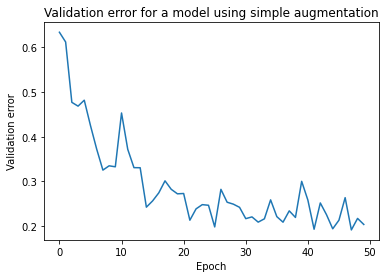

In [34]:
simple_val_acc = p4b_aug_hist.history['val_accuracy']
plt.plot([1 - acc for acc in simple_val_acc])
plt.title('Validation error for a model using simple augmentation')
plt.ylabel('Validation error')
plt.xlabel('Epoch')
plt.savefig('simple_augmentation_error.png')
plt.show()

# Data augmentation using Cutout

Experiment setup:

Model: Resnet44

Parameter to change: Different values of M (2,4,8,16,32)

M is the number of instances generated from an input sample after applying cutout M times effectively increasing the batch size to M · B, where B is the original batch size (before applying cutout augmentation). 

Metrics to observe: validation error (by epoch), wall clock time

In [13]:
cifar10 = tf.keras.datasets.cifar10
(X_train, Y_train),(x_test, y_test) = cifar10.load_data()

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.2)

print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)


#convert to float to normalize
x_train = x_train.astype('float32')/255.0
x_val = x_val.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# Data normalization
m, std = np.mean(X_train), np.std(X_train)
X_train = (X_train - m)/std
x_test = (x_test - m)/std

#categorical format
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

x_train shape: (40000, 32, 32, 3)
x_val shape: (10000, 32, 32, 3)
y_train shape: (40000, 1)
y_val shape: (10000, 1)
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
x_train shape: (40000, 32, 32, 3)
x_val shape: (10000, 32, 32, 3)
y_train shape: (40000, 10)
y_val shape: (10000, 10)


In [5]:
def apply_mask(image, size=12, n_squares=1):
    h, w, channels = image.shape
    new_image = image
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2,x1:x2,:] = 0
    return new_image

In [15]:
def lr_schedule_100(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 50, 65, 75, 85 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 85:
        lr = lr* 0.0005
    elif epoch > 75:
        lr =lr* 0.0001
    elif epoch > 65:
        lr =lr* 0.001
    elif epoch > 50:
        lr =lr* 0.1
    else:
        lr = 1e-3
    print('Learning rate: ', lr)
    return lr


In [7]:
# use generator to feed ResNet batches of images
def batch_generator(x, y, epochs, m, batch_size, augment=None):
    for _ in range(epochs):
        n = x.shape[0]
        reorder = np.random.permutation(n)
        cursor = 0
        while cursor + batch_size < x.shape[0]:
            x_batch = x[reorder[cursor:cursor+batch_size]]
            y_batch = y[reorder[cursor:cursor+batch_size]]
            if augment != None:
                yield np.array([augment(xx) for xx in x_batch for rep in range(m)]), np.array([yy for yy in y_batch for rep in range(m)])
            else:
                yield x_batch, y_batch
            cursor += batch_size

In [14]:
durations = []
val_acc_cutout = []
prob4c_result = []

In [16]:
# Using a different fit function
EPOCH = 100

lr_scheduler = LearningRateScheduler(lr_schedule_100)
#earlyStop = EarlyStopping(monitor = "val_accuracy", patience = 5, restore_best_weights=True)
for i in [8]:
    model = resnet_v1(
        input_shape=x_train.shape[1:],
        depth=44
    )      
    model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(),
        metrics=['accuracy']
    )    
    duration = time.time()
    #x, y, epochs, m, batch_size, augment=None
    hist = model.fit(
        batch_generator(
            x_train,
            y_train,
            100,
            m=i,
            batch_size=64,
            augment=apply_mask
        ),
        epochs=EPOCH, 
        validation_data=(x_val,y_val),
        steps_per_epoch=np.floor((x_train.shape[0])/64.0),
        verbose=2,
        callbacks=[lr_scheduler]
    )
    durations.append(time.time()-duration)
    val_acc_cutout.append(hist.history['val_accuracy'])

version =2 
M =8

for i, val in enumerate(hist.history['val_accuracy']):
    prob4c_result.append([M, version, i, 1-val, durations[0]])

prob4c_df = pd.DataFrame(prob4c_result, 
                         columns = ['M','version','Epochs', 'val_error', 'train_time'])
prob4c_df.to_csv('prob4c_M%.f_version%.f_epoch%.f.csv' %(M, version, EPOCH))

Epoch 1/100
Learning rate:  0.001
625/625 - 366s - loss: 2.2781 - accuracy: 0.2912 - val_loss: 2.5925 - val_accuracy: 0.3096
Epoch 2/100
Learning rate:  0.001
625/625 - 355s - loss: 1.9383 - accuracy: 0.3933 - val_loss: 1.8421 - val_accuracy: 0.4535
Epoch 3/100
Learning rate:  0.001
625/625 - 355s - loss: 1.7716 - accuracy: 0.4390 - val_loss: 1.5710 - val_accuracy: 0.5440
Epoch 4/100
Learning rate:  0.001
625/625 - 355s - loss: 1.6553 - accuracy: 0.4794 - val_loss: 1.9149 - val_accuracy: 0.4748
Epoch 5/100
Learning rate:  0.001
625/625 - 354s - loss: 1.5701 - accuracy: 0.5080 - val_loss: 1.5511 - val_accuracy: 0.5497
Epoch 6/100
Learning rate:  0.001
625/625 - 355s - loss: 1.5040 - accuracy: 0.5316 - val_loss: 1.7258 - val_accuracy: 0.5341
Epoch 7/100
Learning rate:  0.001
625/625 - 354s - loss: 1.4402 - accuracy: 0.5567 - val_loss: 1.5529 - val_accuracy: 0.6043
Epoch 8/100
Learning rate:  0.001
625/625 - 354s - loss: 1.3983 - accuracy: 0.5689 - val_loss: 1.3441 - val_accuracy: 0.6284


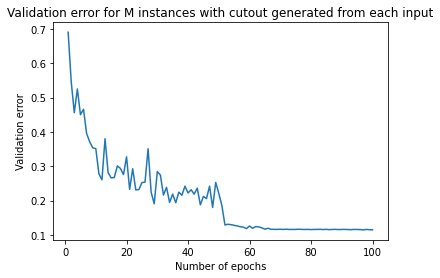

In [26]:
def opp(l):
    return [1-el for el in l]

val_error = [1- val for val in hist.history['val_accuracy']]

plt.plot(range(1,101), val_error)

plt.title("Validation error for M instances with cutout generated from each input")
plt.xlabel("Number of epochs")
plt.ylabel("Validation error")
plt.savefig("acc_cutout_m8.png")
plt.show()

## discussion

Due to the training time required, I saved data for each M separately. Loading each output, the plots look like:

I used virtual machine from GCP and I was able to use one K80. But I could not get access to a better GPU despite requesting multiple times in different days.So I was not able to complete training for M = 16 and M = 32.
I could have used better learning rate schedule to encourage faster training. But since I had already done M = 2 annd 4 with a schedule, changing it midway would have meant my data will not be comparable. In the future, I would follow a similar approach to problem 2.3 instead of defining a learning rate schedule: try candidate learning rates and also add cyclical learning rate with triangular decay.

## results

In [66]:
cutout2 = pd.read_csv('prob4c_M2_version4_epoch100.csv')
cutout4= pd.read_csv('prob4c_M4_version2_epoch100.csv')
cutout8= pd.read_csv('prob4c_M8_version3_epoch100.csv')

# Wall clock time
print(cutout2['train_time'][0]*100) 
print(cutout4['train_time'][0])
print(cutout8['train_time'][0])
##using clock time for 1 epoch for M =2 to extrapolate bc it was overwritten :(

15086.20023727417
20789.735212802887
35389.155172109604


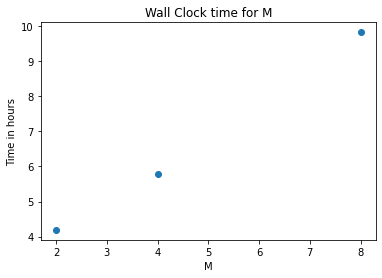

In [76]:
M = [2,4,8]
train_times = [cutout2['train_time'][0]*100/3600, cutout4['train_time'][0]/3600, cutout8['train_time'][0]/3600]
plt.scatter(M, train_times)
plt.title('Wall Clock time for M')
plt.xlabel('M')
plt.ylabel('Time in hours')
plt.show()

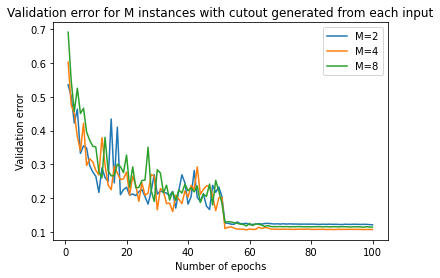

In [57]:
plt.plot(range(1,101), cutout2['val_error'][:100])
plt.plot(range(1,101), cutout4['val_error'][:100])
plt.plot(range(1,101), cutout8['val_error'][:100])
plt.legend(["M=2","M=4","M=8"])
plt.title("Validation error for M instances with cutout generated from each input")
plt.xlabel("Number of epochs")
plt.ylabel("Validation error")
plt.savefig("acc_cutout_all.png")
plt.show()
